In vitro cleavage site mapping using random substrates (Rep1 novaseq70 and Rep 2; novaseq85)
  
Lbu-noPro  
Lbu-16  
Lwa-noPro  
Lwa-16  
Psp-noPro  
Psp-16  
bt3-noPro  
bt3-16  
Rx-noPro  
Rx-16  
dict-oKWW2182  
  
2025.11.18  
2026.01.29  
  
Overview

1. adaptor trimming: use different 3' sequences for dict and clv
2. clv: trim the last 4 nt
3. assign min and max length after cutadapt (MIN: 35 for dict, 1 for clv; MAX: both 35)
4. both: draw a histogram to check the cutoff
5. dict: Get 5' sequences with the selected length
6. pandas: pd.merge. Use the length number to get the sequences near the cleavage position
7. Calculate the mean of each 2/3nt motif
8. Make a scatterplot to compare rep1 and 2 to see which motifs are more frequently cleaved

In [31]:
import pandas as pd
import os
import numpy as np
from collections import Counter
import random
import matplotlib.ticker as ticker
from scipy.stats import mannwhitneyu

In [32]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import seaborn as sns


In [33]:
#nBarcode = 35

lSampleNames1 = ['A1-Lbu-noPro',
                 'A2-Lbu-16',
                 'A3-Lwa-noPro',
                 'A4-Lwa-16',
                 'A7-Psp-noPro',
                 'A8-Psp-16',
                 'A9-bt3-noPro',
                 'A10-bt3-16',
                 'A11-Rx-noPro',
                 'A12-Rx-16']

lSampleNames2 = ['A1-Lbu-noPro',
                 'A2-Lbu-16',
                 'A3-Lwa-noPro',
                 'A4-Lwa-16',
                 'A5-Psp-noPro',
                 'A6-Psp-16',
                 'A7-bt3-noPro',
                 'A8-bt3-16',
                 'A9-Rx-noPro',
                 'A10-Rx-16']

sWorkDir1 = '/home/kwonschul/data/hku_NGS/54_novaseq70_250728/analysis/data/'
sWorkDir2 = '/home/kwonschul/data/hku_NGS/70_novaseq85_251106/analysis/data/'

sDictFile1 = '/home/kwonschul/data/hku_NGS/54_novaseq70_250728/analysis/data/A13-dict-oKW2182.collapsed.tsv'
sDictFile2 = '/home/kwonschul/data/hku_NGS/70_novaseq85_251106/analysis/data/A11-dict-oKW2182.collapsed.tsv'

sOutputDir = '/home/kwonschul/data/hku_NGS/54_novaseq70_250728/analysis/manuscript/'

"""
sWorkDir1 = '/usersdata/joelamkc/project/Cas13/results/251116_novaseq70_analysis/data/'
sWorkDir2 = '/usersdata/joelamkc/project/Cas13/results/251106_novaseq85_analysis/data/'

sDictFile1 = '/usersdata/joelamkc/project/Cas13/results/251116_novaseq70_analysis/data/A13-dict-oKW2182.collapsed.tsv'
sDictFile2 = '/usersdata/joelamkc/project/Cas13/results/251106_novaseq85_analysis/data/A11-dict-oKW2182.collapsed.tsv'
"""

lClvFile1 = list(map(lambda x: sWorkDir1 + x + '.collapsed.tsv', lSampleNames1))
lClvFile2 = list(map(lambda x: sWorkDir2 + x + '.collapsed.tsv', lSampleNames2))


## Dictionary

In [34]:
dfDict1 = pd.read_table(sDictFile1, names=['name', 'seq'], index_col=False)
dfDict2 = pd.read_table(sDictFile2, names=['name', 'seq'], index_col=False)

dfDict1['count'] = dfDict1['name'].apply(lambda x: int(x.split('-')[-1]))
dfDict2['count'] = dfDict2['name'].apply(lambda x: int(x.split('-')[-1]))

dfDict2

,name,seq,count
0,1-1535,TGTAGTCCAAGCGAGGACTGCAAATATTTTCGAGG,1535
1,2-868,GGTAATTACTCCGCGCGGTACCCCGGTCGGGTAGA,868
2,3-718,GGCTGACATAACGTGTCGTTCTGCAATCCACTTCA,718
3,4-640,GCATCTTACATTACATGTATTCGCCCCCTCCTTTT,640
4,5-634,TATGGTTTCTGTTTGCATACTCCGATTGAGTGATT,634
...,...,...,...
145484,145485-1,AGGTCGGGGTCATATTTTTCTACTTACCTCTTACA,1
145485,145486-1,AGCCCGTCGTTTCATGATAGGTGTTTTTGTGTATC,1
145486,145487-1,ATCATCTGTCGTGGTGCAAGAAGGCCTAAGTCATT,1
145487,145488-1,AGGACTCCTGCGCCGCGTCGCTTACCGGTTCGATT,1


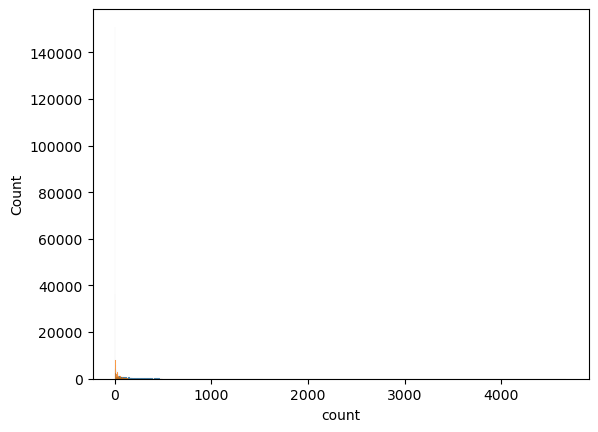

In [35]:
sns.histplot(data=dfDict1, x="count") #, bins=1000)
sns.histplot(data=dfDict2, x="count") #, bins=1000)
plt.show()

In [36]:
nDictCountFilter1 = 100
nDictCountFilter2 = 50
dfDict1 = dfDict1[dfDict1['count']>nDictCountFilter1]
dfDict2 = dfDict2[dfDict2['count']>nDictCountFilter2]
dfDict2

,name,seq,count
0,1-1535,TGTAGTCCAAGCGAGGACTGCAAATATTTTCGAGG,1535
1,2-868,GGTAATTACTCCGCGCGGTACCCCGGTCGGGTAGA,868
2,3-718,GGCTGACATAACGTGTCGTTCTGCAATCCACTTCA,718
3,4-640,GCATCTTACATTACATGTATTCGCCCCCTCCTTTT,640
4,5-634,TATGGTTTCTGTTTGCATACTCCGATTGAGTGATT,634
...,...,...,...
25967,25968-51,TAGCAGTGGATGTGTCGCTCTCTTCTAGGTTGGAC,51
25968,25969-51,ATTTTGTTGTATTGACCGGGATAGTTTTTTACCCA,51
25969,25970-51,GCACTCGTACGCCACCGTATGTGCCGCGTGGGACT,51
25970,25971-51,AGGTCCTCTCCCCATTCGTCCTTGAGGTAGCGACT,51


In [37]:
print('Dictionary expression level filter: {} reads'.format(nDictCountFilter1))
print('Number of unique 35mer substrates in dictionary, Rep1: {}'.format(len(dfDict1)))
print('Sum of all read counts in dictionary, Rep1: {}'.format(dfDict1['count'].sum()))
print('Median of the number of reads per unique substrate: {}'.format(dfDict1['count'].median()))
print('--')
print('Dictionary expression level filter: {} reads'.format(nDictCountFilter2))
print('Number of unique 35mer substrates in dictionary, Rep2: {}'.format(len(dfDict2)))
print('Sum of all read counts in dictionary, Rep2: {}'.format(dfDict2['count'].sum()))
print('Median of the number of reads per unique substrate: {}'.format(dfDict2['count'].median()))



Dictionary expression level filter: 100 reads
Number of unique 35mer substrates in dictionary, Rep1: 50784
Sum of all read counts in dictionary, Rep1: 14831460
Median of the number of reads per unique substrate: 230.0
--
Dictionary expression level filter: 50 reads
Number of unique 35mer substrates in dictionary, Rep2: 25972
Sum of all read counts in dictionary, Rep2: 2223872
Median of the number of reads per unique substrate: 75.0


<function matplotlib.pyplot.close(fig=None)>

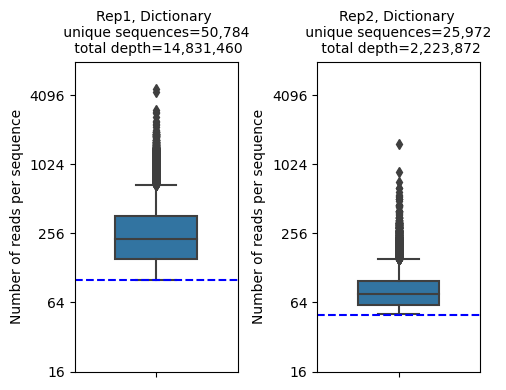

In [57]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 4))

# Plot 1
sns.boxplot(y='count', data=dfDict1, ax=axes[0], width=0.5)
axes[0].set_title('Rep1, Dictionary \n unique sequences={:,} \n total depth={:,}'.format(len(dfDict1), dfDict1['count'].sum()) ,
                 fontsize=10)
axes[0].set_ylabel('Number of reads per sequence')
axes[0].axhline(y=nDictCountFilter1, color='blue', linestyle='--')
axes[0].set_ylim([16, 8000])

axes[0].set_yscale('log', base=2)
axes[0].yaxis.set_major_locator(ticker.LogLocator(base=2))
axes[0].get_yaxis().set_major_formatter(ticker.ScalarFormatter())

# Plot 2
sns.boxplot(y='count', data=dfDict2, ax=axes[1], width=0.5)
axes[1].set_title('Rep2, Dictionary \n unique sequences={:,} \n total depth={:,}'.format(len(dfDict2), dfDict2['count'].sum()) ,
                 fontsize=10)
axes[1].set_ylabel('Number of reads per sequence')
axes[1].axhline(y=nDictCountFilter2, color='blue', linestyle='--')
axes[1].set_ylim([16, 8000])

axes[1].set_yscale('log', base=2)
axes[1].yaxis.set_major_locator(ticker.LogLocator(base=2))
axes[1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())

# show
plt.tight_layout()
#plt.show()
plt.savefig(sOutputDir + 'dict_depth.png', dpi=1200)
plt.close

## Cleavage fragments: all samples


In [40]:
# Process and put all samples in a list ("lMappedClv")

#----------------------------------------------------------------
# Replicate variables

"""
sLabelRep = 'Rep1'
sWorkDir = sWorkDir1
dfDict = dfDict1
lClvFile = lClvFile1
lMappedClv1 = []
lMappedClv = lMappedClv1 

"""
sLabelRep = 'Rep2'
sWorkDir = sWorkDir2
dfDict = dfDict2
lClvFile = lClvFile2
lMappedClv2 = []
lMappedClv = lMappedClv2

#----------------------------------------------------------------
# Other variables

nClvCountFilter = 20

# For initial 8 nt motif
nOffset_set0_5 = 4 # minus 4 nt
nOffset_set0_3 = 4 # plus 4 nt

# For 3 nt motif (-2:+1)
nOffset_set1_5 = 2 # minus 2 nt
nOffset_set1_3 = 1 # plus 1 nt

# For 2 nt motif (-1:+1)
nOffset_set2_5 = 1 # minus 1 nt
nOffset_set2_3 = 1 # plus 1 nt

nTopNumber = 4000 # analyze top 4000 sequences

nMinInsertLen = 15 # Included
nMaxInsertLen = 25 # Not included

#----------------------------------------------------------------
lSelectedInsertLen = np.arange(nMinInsertLen,nMaxInsertLen,1)

for i, sClvFile in enumerate(lClvFile):
    sClvName = sClvFile.split('/')[-1].split('.collapsed.tsv')[0]
    
    dfClv = pd.read_table(sClvFile, names=['name', 'seq'], index_col=False)
    dfClv['count'] = dfClv['name'].apply(lambda x: int(x.split('-')[-1]))

    dfClv = dfClv[dfClv['count']>nClvCountFilter]
    dfClv['insertlen'] = dfClv['seq'].apply(lambda x: int(len(x)))

    dfClv = dfClv[dfClv['insertlen'] >= nMinInsertLen]
    dfClv = dfClv[dfClv['insertlen'] < nMaxInsertLen]

    
    lAllDf = []
    for nSelectedInsertLen in lSelectedInsertLen:
    
        dfClvOne = dfClv[dfClv['insertlen']==nSelectedInsertLen]
        dfDictOne = dfDict.copy()
        dfDictOne['5pSeq'] = dfDictOne['seq'].apply(lambda x: x[:nSelectedInsertLen])
        dfDictOne['8nt_motif'] = dfDictOne['seq'].apply(lambda x: x[nSelectedInsertLen-nOffset_set0_5:nSelectedInsertLen+nOffset_set0_3])
        dfDictOne['3nt_motif'] = dfDictOne['seq'].apply(lambda x: x[nSelectedInsertLen-nOffset_set1_5:nSelectedInsertLen+nOffset_set1_3])
        dfDictOne['2nt_motif'] = dfDictOne['seq'].apply(lambda x: x[nSelectedInsertLen-nOffset_set2_5:nSelectedInsertLen+nOffset_set2_3])
        
        dfClvOne = dfClvOne.rename(columns={"name": "clv_name", "seq": "clv_seq", "count": "clv_count"})
        dfDictOne = dfDictOne.rename(columns={"name": "dict_name", "seq": "dict_seq", "count": "dict_count"})
        dfClvOneMapped = pd.merge(dfClvOne, dfDictOne, how='left', left_on='clv_seq', right_on='5pSeq')
        dfClvOneMapped = dfClvOneMapped.dropna()
        dfClvOneMapped['clvOverDict'] = dfClvOneMapped.apply(lambda row: row['clv_count'] / float(row['dict_count']), axis=1)
    
        lAllDf.append(dfClvOneMapped)
    
    dfClvConcat = pd.concat(lAllDf)
    dfClvConcat = dfClvConcat.sort_values(by='clvOverDict', ascending=False)
    dfClvConcat = dfClvConcat.reset_index(drop=True)

    
    # Create a rank column (1-based rank)
    dfClvConcat['rank'] = dfClvConcat['clvOverDict'].rank(method='first', ascending=False)
    dfClvConcat['rank'] = dfClvConcat['rank'].astype(int)

    lMappedClv.append([sLabelRep, sClvName, dfClvConcat])


## Repeat the above cell with a different variable-----------------------------------

In [41]:
lMappedClv2

[['Rep2',
  'A1-Lbu-noPro',
          clv_name                   clv_seq  clv_count  insertlen dict_name  \
  0        608-969           AATTTTCACCCTCTT        969         15  25629-51   
  1        605-974  TATATTTCTTTATAAAATAAGATT        974         24  24883-52   
  2        679-908    GTCTTGAACACACGGGTCTCCA        908         22  25726-51   
  3        668-916          TGGGGAATTATTCACA        916         16  24190-53   
  4       379-1445          TACCCTCTGGTTCTGA       1445         16   9784-84   
  ...          ...                       ...        ...        ...       ...   
  15575  108490-31      TAGGTCCGCTGTGGTTTCTC         31         20    25-395   
  15576  111215-26      AACATGAACGTACGATGTTT         26         20    20-404   
  15577  113658-22          TTGTCCGCTGACCAAA         22         16    28-368   
  15578   71571-78      TGTAGTCCAAGCGAGGACTG         78         20    1-1535   
  15579  107471-32     TATGGTTTCTGTTTGCATACT         32         21     5-634   
  
         

<function matplotlib.pyplot.close(fig=None)>

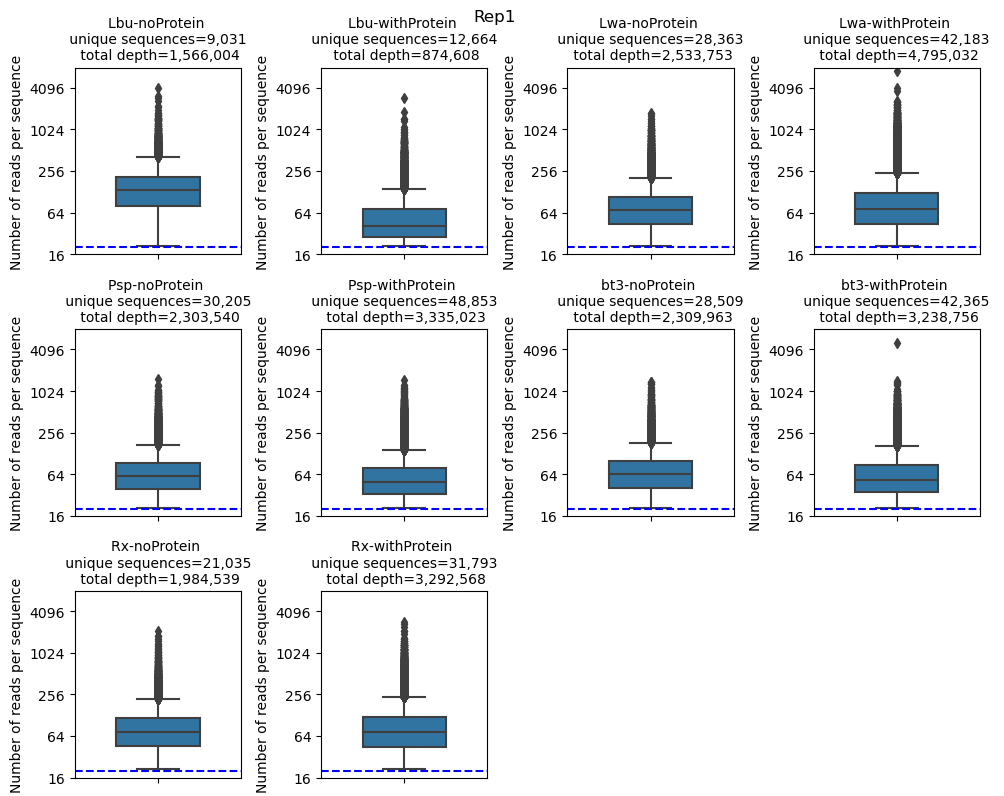

In [51]:
# Distribution of reads per sequence (mapped reads on dictionary)
#----------------------------------------------------------------
# Rep variables
lMappedClv = lMappedClv1
#lMappedClv = lMappedClv2
#----------------------------------------------------------------

#----------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))  
for i, (sLabelRep, sClvName, dfClvConcat) in enumerate(lMappedClv):

    sClvName = '-'.join(sClvName.split('-')[1:]).replace('noPro', 'noProtein').replace('16','withProtein')
    ax = fig.add_subplot(3, 4, i+1)
    
    sns.boxplot(y='clv_count', data=dfClvConcat, ax=ax, width=0.5)
    ax.set_title('{} \n unique sequences={:,} \n total depth={:,}'.format(sClvName, len(dfClvConcat), dfClvConcat['clv_count'].sum()),
                fontsize=10)
    ax.set_ylabel('Number of reads per sequence')
    ax.axhline(y=nClvCountFilter, color='blue', linestyle='--')
    ax.set_ylim([16, 8000])
    
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_locator(ticker.LogLocator(base=2))
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    

plt.tight_layout()
plt.suptitle(sLabelRep, y=0.99)
#plt.show()
plt.savefig(sOutputDir + 'clv1_depth.png', dpi=1200)
plt.close

<function matplotlib.pyplot.close(fig=None)>

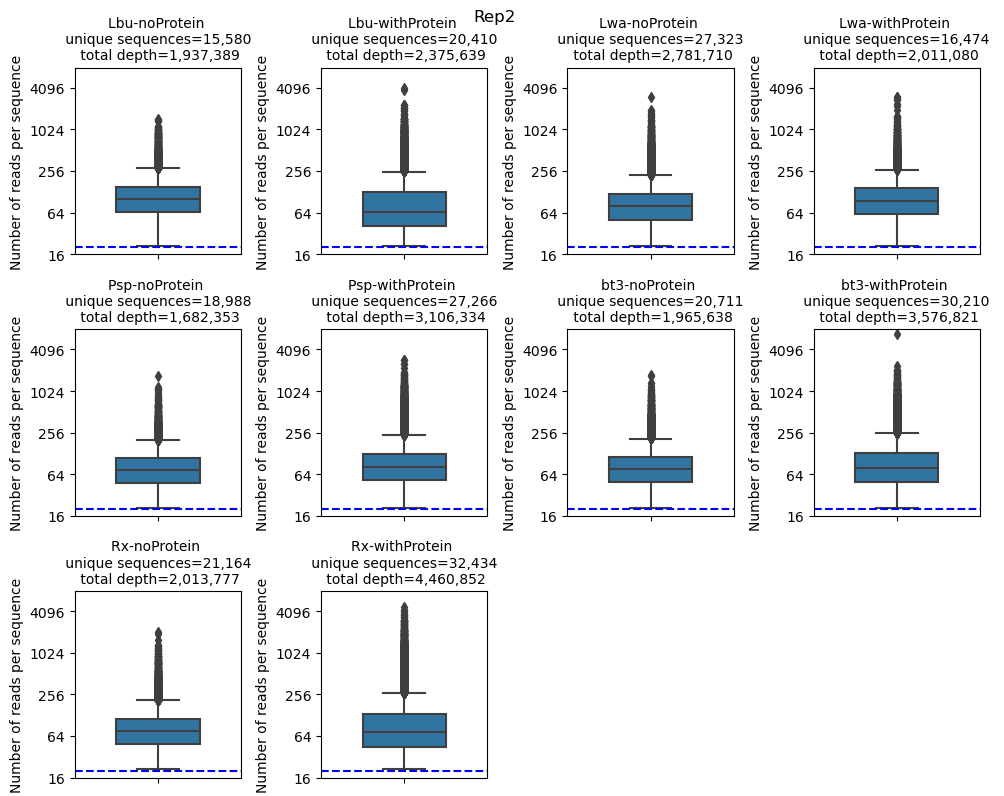

In [52]:
# Distribution of reads per sequence (mapped reads on dictionary)
#----------------------------------------------------------------
# Rep variables
#lMappedClv = lMappedClv1
lMappedClv = lMappedClv2
#----------------------------------------------------------------

#----------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))  
for i, (sLabelRep, sClvName, dfClvConcat) in enumerate(lMappedClv):

    sClvName = '-'.join(sClvName.split('-')[1:]).replace('noPro', 'noProtein').replace('16','withProtein')
    ax = fig.add_subplot(3, 4, i+1)
    
    sns.boxplot(y='clv_count', data=dfClvConcat, ax=ax, width=0.5)
    ax.set_title('{} \n unique sequences={:,} \n total depth={:,}'.format(sClvName, len(dfClvConcat), dfClvConcat['clv_count'].sum()),
                fontsize=10)
    ax.set_ylabel('Number of reads per sequence')
    ax.axhline(y=nClvCountFilter, color='blue', linestyle='--')
    ax.set_ylim([16, 8000])
    
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_locator(ticker.LogLocator(base=2))
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    

plt.tight_layout()
plt.suptitle(sLabelRep, y=0.99)
#plt.show()
plt.savefig(sOutputDir + 'clv2_depth.png', dpi=1200)
plt.close

<function matplotlib.pyplot.close(fig=None)>

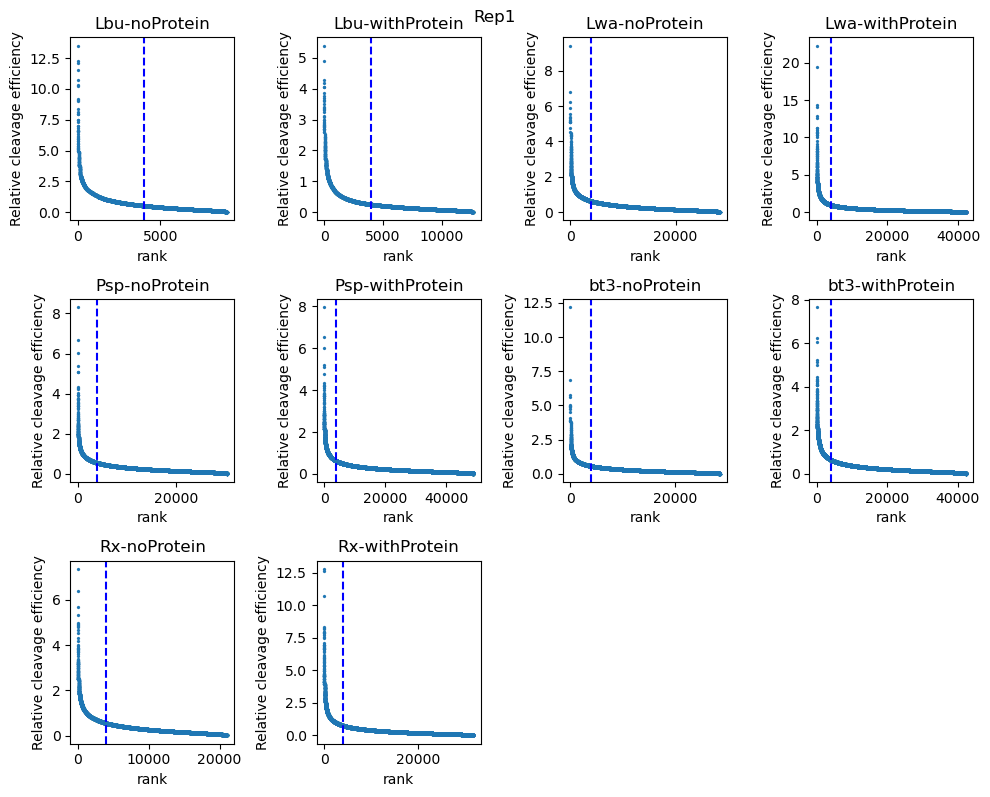

In [53]:
# x axis: sorted ranking
# y axis: cleavage efficiency
# axvline: 4000th ranking
#----------------------------------------------------------------
# Rep variables
lMappedClv = lMappedClv1
#lMappedClv = lMappedClv2
#----------------------------------------------------------------
nTopNumber = 4000 # analyze top 4000 sequences
#----------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))  
for i, (sLabelRep, sClvName, dfClvConcat) in enumerate(lMappedClv):
    
    sClvName = '-'.join(sClvName.split('-')[1:]).replace('noPro', 'noProtein').replace('16','withProtein')
    ax = fig.add_subplot(3, 4, i+1)
    
    sns.scatterplot(x='rank', y='clvOverDict', data=dfClvConcat, alpha=1, s=5, color='tab:blue', edgecolor='tab:blue', linewidth=0.1, ax=ax)
    ax.set_title('{}'.format(sClvName))
    ax.set_ylabel('Relative cleavage efficiency')
    ax.axvline(x=nTopNumber, color='blue', linestyle='--')

plt.tight_layout()
plt.suptitle(sLabelRep, y=0.99)
#plt.show()
plt.savefig(sOutputDir + 'clv1_effi.png', dpi=1200)
plt.close

<function matplotlib.pyplot.close(fig=None)>

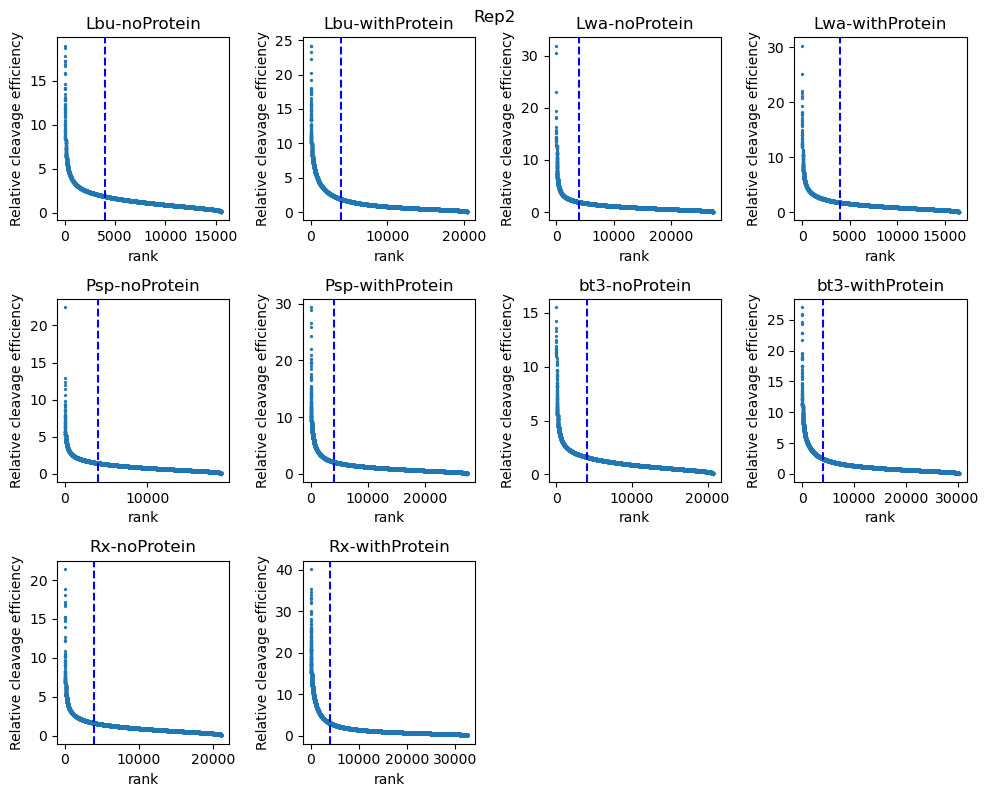

In [54]:
# x axis: sorted ranking
# y axis: cleavage efficiency
# axvline: 4000th ranking
#----------------------------------------------------------------
# Rep variables
#lMappedClv = lMappedClv1
lMappedClv = lMappedClv2
#----------------------------------------------------------------
nTopNumber = 4000 # analyze top 4000 sequences
#----------------------------------------------------------------
fig = plt.figure(figsize=(10, 8))  
for i, (sLabelRep, sClvName, dfClvConcat) in enumerate(lMappedClv):
    
    sClvName = '-'.join(sClvName.split('-')[1:]).replace('noPro', 'noProtein').replace('16','withProtein')
    ax = fig.add_subplot(3, 4, i+1)
        
    sns.scatterplot(x='rank', y='clvOverDict', data=dfClvConcat, alpha=1, s=5, color='tab:blue', edgecolor='tab:blue', linewidth=0.1, ax=ax)
    ax.set_title('{}'.format(sClvName))
    ax.set_ylabel('Relative cleavage efficiency')
    ax.axvline(x=nTopNumber, color='blue', linestyle='--')

plt.tight_layout()
plt.suptitle(sLabelRep, y=0.99)
#plt.show()
plt.savefig(sOutputDir + 'clv2_effi.png', dpi=1200)
plt.close

In [25]:
# Check whether the sample order is correct
lZipMappedClv = list(zip(lMappedClv1, lMappedClv2))
for i,j in lZipMappedClv:
    print(i[1], j[1])

A1-Lbu-noPro A1-Lbu-noPro
A2-Lbu-16 A2-Lbu-16
A3-Lwa-noPro A3-Lwa-noPro
A4-Lwa-16 A4-Lwa-16
A7-Psp-noPro A5-Psp-noPro
A8-Psp-16 A6-Psp-16
A9-bt3-noPro A7-bt3-noPro
A10-bt3-16 A8-bt3-16
A11-Rx-noPro A9-Rx-noPro
A12-Rx-16 A10-Rx-16


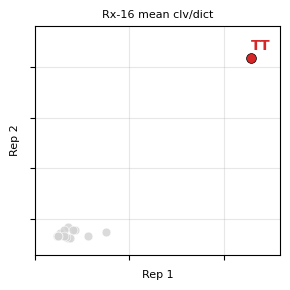

In [26]:
# cleavage efficiency (2nt motif)
# x axis: Rep1
# y axis: Rep2

#----------------------------------------------------------------
# variables
"""
sTargetSampleName = 'Lbu-16'
sMotifType = '2nt_motif'
nTopMotifNumber = 5
nBottomMotifNumber = 0
lX_lim = [0.1, 0.37]
lY_lim = [0.4, 1.9]
sOutputFile = 'motif_Lbu.pdf'

sTargetSampleName = 'Lwa-16'
sMotifType = '2nt_motif'
nTopMotifNumber = 3
nBottomMotifNumber = 0
lX_lim = [0.22, 0.6]
lY_lim = [0.9, 1.9]
sOutputFile = 'motif_Lwa.pdf'

sTargetSampleName = 'bt3-16'
sMotifType = '2nt_motif'
nTopMotifNumber = 1
nBottomMotifNumber = 0
lX_lim = [0.2, 0.45]
lY_lim = [0.75, 2.45]
sOutputFile = 'motif_bt3.pdf'
"""
sTargetSampleName = 'Rx-16'
sMotifType = '2nt_motif'
nTopMotifNumber = 1
nBottomMotifNumber = 0
lX_lim = [0.3, 0.56]
lY_lim = [0.65, 2.9]
sOutputFile = 'motif_Rx.pdf'

#----------------------------------------------------------------

for i, (xRep1, xRep2) in enumerate(lZipMappedClv):    
    sClvNameRep1 = xRep1[0] + '_' + xRep1[1] #e.g., Rep1_A1-Lbu-noPro
    sClvNameRep2 = xRep2[0] + '_' + xRep2[1] #e.g., Rep2_A1-Lbu-noPro

    sSampleName = '-'.join(sClvNameRep1.split('-')[1:])
    if sSampleName != sTargetSampleName:
        continue
    
    dfClvRep1 = xRep1[2]
    dfClvRep2 = xRep2[2]
    
    ave1 = dfClvRep1[[sMotifType, 'clvOverDict']].groupby(sMotifType)['clvOverDict'].mean().reset_index()
    ave1.columns = [sMotifType, 'mean_clvOverDict']
    
    ave2 = dfClvRep2[[sMotifType, 'clvOverDict']].groupby(sMotifType)['clvOverDict'].mean().reset_index()
    ave2.columns = [sMotifType, 'mean_clvOverDict']

    #---------------------------------------------------
    # Merge on nearbyseq
    merged = ave1.merge(ave2, on=sMotifType, suffixes=('_rep1', '_rep2')).dropna()

    # Average of the two replicates – used for ranking
    merged['avg'] = merged[['mean_clvOverDict_rep1', 'mean_clvOverDict_rep2']].mean(axis=1)
    
    # Identify top and bottom sequences
    top    = merged.nlargest(nTopMotifNumber, 'avg')
    bottom = merged.nsmallest(nBottomMotifNumber, 'avg')
    
    # Everything else
    others  = merged.drop(index=top.index.tolist() + bottom.index.tolist())

    #---------------------------------------------------
    # Start plotting
    
    plt.figure(figsize=(3, 3))
    # 1. Gray background points
    sns.scatterplot(data=others,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='lightgray', s=40, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # 2. Bottom 2 → blue
    sns.scatterplot(data=bottom,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='tab:blue', s=50, edgecolor='black', linewidth=0.5,
                    label='Bottom {} (lowest)'.format(nBottomMotifNumber))

    # 2-b. LwaCas13a's CT ----------------------------------------------------------
    if sTargetSampleName == 'Lwa-16':
        df_interest = others[others[sMotifType] == 'CT']
        sns.scatterplot(data=df_interest,
                        x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                        color='tab:blue', s=50, edgecolor='black', linewidth=0.5,
                        label='Bottom {} (lowest)'.format(nBottomMotifNumber))
        lLabelColor = [(top, 'tab:red'), (bottom, 'tab:blue'), (df_interest, 'tab:blue')]
    else:
        lLabelColor = [(top, 'tab:red'), (bottom, 'tab:blue')]
    # 2-b. LwaCas13a's CT end ----------------------------------------------------------
                       
    # 3. Top 6 → red
    sns.scatterplot(data=top,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='tab:red', s=50, edgecolor='black', linewidth=0.5,
                    label='Top {} (highest)'.format(nTopMotifNumber))
    
    # Add labels (only for top + bottom)
    for df, color in lLabelColor:
        for _, row in df.iterrows():
            plt.text(row['mean_clvOverDict_rep1'],   # slight offset
                     row['mean_clvOverDict_rep2'] + 0.05,
                     row[sMotifType],
                     fontsize=10, fontweight='bold',
                     color=color,
                     ha='left', va='bottom')
    
    
    # Cosmetics
    plt.xlim(lX_lim)
    plt.ylim(lY_lim)
    plt.xlabel('Rep 1', fontsize=8)
    plt.ylabel('Rep 2', fontsize=8)
    plt.title(sSampleName + ' mean clv/dict', fontsize=8)
    #plt.legend(loc='upper left')
    plt.legend().set_visible(False)
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    #plt.savefig(sOutputDir + sOutputFile)
    plt.close

## Run the above cell with different variables------------------------------

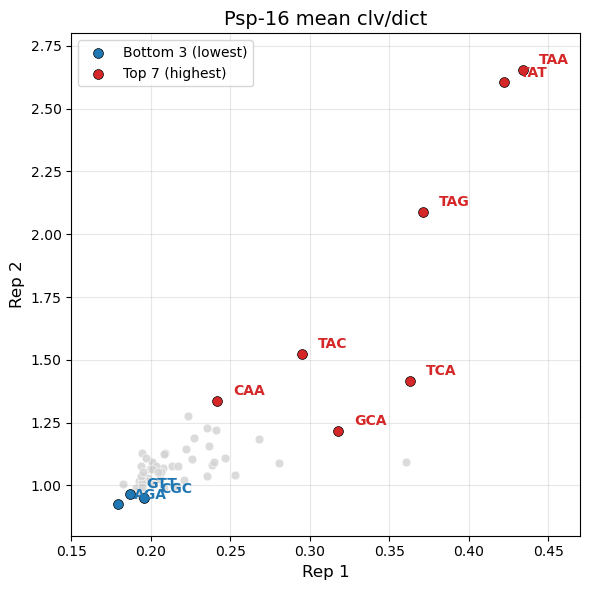

In [27]:
# cleavage efficiency (3nt motif)
# x axis: Rep1
# y axis: Rep2

#----------------------------------------------------------------
# variables


sTargetSampleName = 'Psp-16'
sMotifType = '3nt_motif'
nTopMotifNumber = 7
nBottomMotifNumber = 3
sOutputFile = 'motif_Psp.pdf'
#----------------------------------------------------------------



for i, (xRep1, xRep2) in enumerate(lZipMappedClv):    
    sClvNameRep1 = xRep1[0] + '_' + xRep1[1] #e.g., Rep1_A1-Lbu-noPro
    sClvNameRep2 = xRep2[0] + '_' + xRep2[1] #e.g., Rep2_A1-Lbu-noPro

    sSampleName = '-'.join(sClvNameRep1.split('-')[1:])
    if sSampleName != sTargetSampleName:
        continue
    
    dfClvRep1 = xRep1[2]
    dfClvRep2 = xRep2[2]
    
    ave1 = dfClvRep1[[sMotifType, 'clvOverDict']].groupby(sMotifType)['clvOverDict'].mean().reset_index()
    ave1.columns = [sMotifType, 'mean_clvOverDict']
    
    ave2 = dfClvRep2[[sMotifType, 'clvOverDict']].groupby(sMotifType)['clvOverDict'].mean().reset_index()
    ave2.columns = [sMotifType, 'mean_clvOverDict']

    #---------------------------------------------------
    # Merge on nearbyseq
    merged = ave1.merge(ave2, on=sMotifType, suffixes=('_rep1', '_rep2')).dropna()

    # Average of the two replicates – used for ranking
    merged['avg'] = merged[['mean_clvOverDict_rep1', 'mean_clvOverDict_rep2']].mean(axis=1)
    
    # Identify top and bottom sequences
    top    = merged.nlargest(nTopMotifNumber, 'avg')
    bottom = merged.nsmallest(nBottomMotifNumber, 'avg')
    
    # Everything else
    others  = merged.drop(index=top.index.tolist() + bottom.index.tolist())

    #---------------------------------------------------
    # Start plotting
    
    plt.figure(figsize=(6, 6))
    # 1. Gray background points
    sns.scatterplot(data=others,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='lightgray', s=40, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # 2. Bottom 2 → blue
    sns.scatterplot(data=bottom,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='tab:blue', s=50, edgecolor='black', linewidth=0.5,
                    label='Bottom {} (lowest)'.format(nBottomMotifNumber))
    
    # 3. Top 6 → red
    sns.scatterplot(data=top,
                    x='mean_clvOverDict_rep1', y='mean_clvOverDict_rep2',
                    color='tab:red', s=50, edgecolor='black', linewidth=0.5,
                    label='Top {} (highest)'.format(nTopMotifNumber))
    
    # Add labels (only for top 6 + bottom 2)
    
    for df, color in [(top, 'tab:red'), (bottom, 'tab:blue')]:
        for _, row in df.iterrows():
            plt.text(row['mean_clvOverDict_rep1']+0.01,   # slight offset
                     row['mean_clvOverDict_rep2'] + 0.01,
                     row[sMotifType],
                     fontsize=10, fontweight='bold',
                     color=color,
                     ha='left', va='bottom')
    
    
    # Cosmetics

    lX_lim = [0.15, 0.47]
    lY_lim = [0.8, 2.8]
    
    plt.xlim(lX_lim)
    plt.ylim(lY_lim)
    plt.xlabel('Rep 1', fontsize=12)
    plt.ylabel('Rep 2', fontsize=12)
    plt.title(sSampleName + ' mean clv/dict', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Optional: save high-res figure
    #plt.savefig(savepath + 'Psp-16-scatter_251118.svg')
    
    plt.show()
    #plt.savefig(sOutputDir + sOutputFile)
    plt.close

In [28]:
# Write tables
nTopNumber = 4000

sOutputTopSequences = sOutputDir + 'TopSeqForLogo_260129v1.xlsx'
sOutputMappedClv =    sOutputDir + 'MappedClvSeq_260129v1.xlsx'

#--------------------------------------------------------------
lAllMappedClv = lMappedClv1 + lMappedClv2

with pd.ExcelWriter(sOutputTopSequences, engine='xlsxwriter') as f1, pd.ExcelWriter(sOutputMappedClv, engine='xlsxwriter') as f2:
    for sLabelRep, sClvName, dfClvConcat in lAllMappedClv:
        dfClvConcat['dict_count'] = dfClvConcat['dict_count'].astype(int)
        
        sSampleName = '-'.join(sClvName.split('-')[1:])
        sSampleName = sSampleName.replace('noPro','noProtein')
        sSampleName = sSampleName.replace('16','withProtein')
    
        sOutputName = sLabelRep + '-' + sSampleName
        print(sOutputName)
    
        #----------------------------------------------------------
        # (1) Write top sequences for pLogo
        seriesClvConcatTop = dfClvConcat.iloc[:nTopNumber,]['8nt_motif']
        
        seriesClvConcatTop.to_excel(f1, sheet_name=sOutputName, index=False)
        #----------------------------------------------------------
        # (2) Write the whole dataframe
        dfClvConcat.to_excel(f2, sheet_name=sOutputName, index=False)

Rep1-Lbu-noProtein
Rep1-Lbu-withProtein
Rep1-Lwa-noProtein
Rep1-Lwa-withProtein
Rep1-Psp-noProtein
Rep1-Psp-withProtein
Rep1-bt3-noProtein
Rep1-bt3-withProtein
Rep1-Rx-noProtein
Rep1-Rx-withProtein
Rep2-Lbu-noProtein
Rep2-Lbu-withProtein
Rep2-Lwa-noProtein
Rep2-Lwa-withProtein
Rep2-Psp-noProtein
Rep2-Psp-withProtein
Rep2-bt3-noProtein
Rep2-bt3-withProtein
Rep2-Rx-noProtein
Rep2-Rx-withProtein


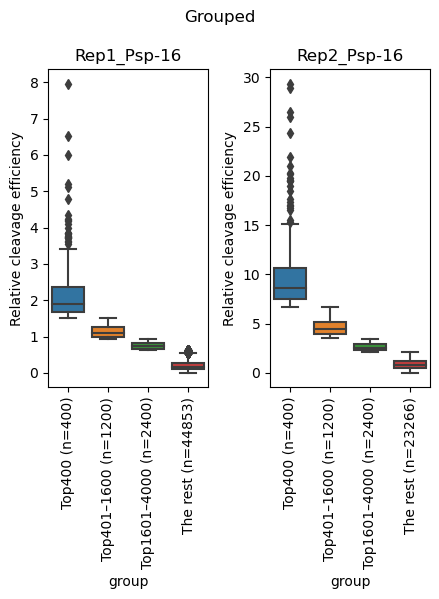

In [29]:
#----------------------------------------------------------------
# Psp boxplot
sTargetSampleName = 'Psp-16'

bins = [0, 400, 1600, 4000, float('inf')]
labels = ['Top400', 'Top401–1600', 'Top1601–4000', 'The rest']

#----------------------------------------------------------------

fig = plt.figure(figsize=(4.5,6))
i = 0
for sLabelRep, sClvName, dfClvConcat in lAllMappedClv:
    
    sSampleName = '-'.join(sClvName.split('-')[1:])
    
    if sTargetSampleName != sSampleName:
        continue
    i += 1
    sRepSampleName = sLabelRep + '_' + sSampleName

    # Assign groups based on rank ranges    
    dfClvConcat['group'] = pd.cut(dfClvConcat['rank'], bins=bins, labels=labels, right=True)

    # Draw a box plot showing the cleavage efficiency among groups (for only Psp)    

    ax = fig.add_subplot(1, 2, i)
    
    #sns.scatterplot(x='rank', y='clvOverDict', data=dfClvConcat, ax=ax)
    #ax.set_title('{}'.format(sClvName))
    #ax.set_ylabel('Relative cleavage efficiency')
    #ax.axvline(x=nTopNumber, color='blue', linestyle='--')
    
    counts = dfClvConcat['group'].value_counts()
    
    sns.boxplot(data = dfClvConcat, x='group', y='clvOverDict', ax=ax)
    xticks = ax.get_xticks()
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    
    # Append the count to each label
    new_labels = []
    for label in xticklabels:
        count = counts[label]
        new_label = f"{label} (n={count})"
        new_labels.append(new_label)
    
    # Set the new labels
    ax.set_xticklabels(new_labels, rotation=90)
    ax.set_title('{}'.format(sRepSampleName))      
    ax.set_ylabel('Relative cleavage efficiency')
plt.suptitle('Grouped', y=0.99)
plt.tight_layout()
plt.show()
#plt.savefig(sOutputDir + 'grouped_psp_box.pdf')
plt.close()




Rep1 TAT vs. GTT, Mann-Whitney-U, p-value: 3.814863276654119e-72
Rep1 TCA vs. GTT, Mann-Whitney-U, p-value: 1.3662724960478312e-59
Rep1 CAA vs. GTT, Mann-Whitney-U, p-value: 3.737912454453575e-05
Rep2 TAT vs. GTT, Mann-Whitney-U, p-value: 6.746882110855267e-78
Rep2 TCA vs. GTT, Mann-Whitney-U, p-value: 1.5213991220446083e-10
Rep2 CAA vs. GTT, Mann-Whitney-U, p-value: 1.1095400841671053e-07


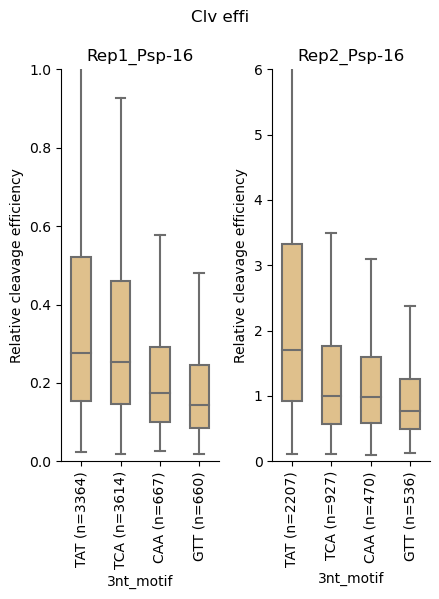

In [30]:
#----------------------------------------------------------------
# Psp TCA motif
sTargetSampleName = 'Psp-16'
lSelectedMotifs = ['TAT', 'TCA', 'CAA', 'GTT']
#----------------------------------------------------------------

fig = plt.figure(figsize=(4.5,6))
i = 0
for sLabelRep, sClvName, dfClvConcat in lAllMappedClv:
    
    sSampleName = '-'.join(sClvName.split('-')[1:])
    
    if sTargetSampleName != sSampleName:
        continue
    i += 1
    sRepSampleName = sLabelRep + '_' + sSampleName
    

    filtered_dfClvConcat = dfClvConcat[dfClvConcat['3nt_motif'].isin(lSelectedMotifs)]


    # Calculate mean and count for each '3nt_motif'
    group_stats = filtered_dfClvConcat.groupby('3nt_motif')['clvOverDict'].agg(['mean', 'count']).reset_index()
    
    # Create labels with motif and count
    group_stats['label'] = group_stats.apply(
        lambda row: f"{row['3nt_motif']} (n={row['count']})", axis=1
    )
    #print(group_stats)
    
    # Sort by mean descending
    group_stats_sorted = group_stats.sort_values('mean', ascending=False)
    #print(group_stats_sorted)
    
    # Get the ordered list of motifs
    ordered_motifs = group_stats_sorted['3nt_motif'].tolist()
    #print(ordered_motifs)
    
    # Create a mapping from motif to label
    label_map = dict(zip(group_stats_sorted['3nt_motif'], group_stats_sorted['label']))
    #print(label_map)
    
    # Draw a box plot showing the cleavage efficiency among groups (for only Psp)    
    ax = fig.add_subplot(1, 2, i)

    #sns.stripplot(data=filtered_dfClvConcat, y='clvOverDict', x='3nt_motif', order=ordered_motifs, color='tab:blue', alpha=0.7, size=3, ax=ax)
    sns.boxplot(data=filtered_dfClvConcat, y='clvOverDict', x='3nt_motif', 
                order=ordered_motifs, color='#edc47e', width=0.5, showfliers=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_xticklabels([label_map[motif] for motif in ordered_motifs], rotation=90)
    ax.set_title('{}'.format(sRepSampleName))      
    ax.set_ylabel('Relative cleavage efficiency')

    if sLabelRep == 'Rep1':
        ax.set_ylim([0,1])
    elif sLabelRep == 'Rep2':
        ax.set_ylim([0,6])
    # Separate the data into two groups
    groupTAT = filtered_dfClvConcat[filtered_dfClvConcat['3nt_motif'] == 'TAT']['clvOverDict']
    groupTCA = filtered_dfClvConcat[filtered_dfClvConcat['3nt_motif'] == 'TCA']['clvOverDict']
    groupCAA = filtered_dfClvConcat[filtered_dfClvConcat['3nt_motif'] == 'CAA']['clvOverDict']
    groupGTT = filtered_dfClvConcat[filtered_dfClvConcat['3nt_motif'] == 'GTT']['clvOverDict']
    
    # Perform Mann-Whitney U test
    p_value_TAToverGTT = mannwhitneyu(groupTAT, groupGTT, alternative='two-sided').pvalue
    p_value_TCAoverGTT = mannwhitneyu(groupTCA, groupGTT, alternative='two-sided').pvalue
    p_value_CAAoverGTT = mannwhitneyu(groupCAA, groupGTT, alternative='two-sided').pvalue

    print('{} TAT vs. GTT, Mann-Whitney-U, p-value: {:,}'.format(sLabelRep, p_value_TAToverGTT))
    print('{} TCA vs. GTT, Mann-Whitney-U, p-value: {:,}'.format(sLabelRep, p_value_TCAoverGTT))
    print('{} CAA vs. GTT, Mann-Whitney-U, p-value: {:,}'.format(sLabelRep, p_value_CAAoverGTT))
    
    
plt.suptitle('Clv effi', y=0.99)
plt.tight_layout()
plt.show()  
#plt.savefig(sOutputDir + 'Psp_TCA_box.pdf')
plt.close()